In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp,Operator
from qiskit.primitives import Estimator
import scipy.linalg as la

## Fermi Hubbard Model : 3 sites
1. A unitary has to be defined to create the ansatz
2. Determine the expectation value
3. Go for gradient descend
4. Define the Hamiltonian
   \begin{equation}
   H = -t \sum_{\langle ij \rangle,\sigma} (c_{i,\sigma}^\dagger c_{j,\sigma} + c_{j,\sigma}^\dagger c_{i,\sigma}) + U \sum_{i} n_{i,\uparrow} n_{i,\downarrow}
   \end{equation}

### Define Parameters

In [17]:
nsite = 3
numq = 2*nsite
max_step = 10
t = 2.0
U = 1.0

### Set the Hamiltonian Matrix

In [18]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])
 
string = numq*[I]
C = []
for i in range(numq):
    string[0:i] = i*[Z]
    string[i] = 0.5*(X + 1j*Y)
    total = string[0]
    for j in range(1,numq):
        total = np.kron(total,string[j])

    C.append(total)

Hopp = np.zeros([2**numq,2**numq])
Self = np.zeros([2**numq,2**numq])

for j in range(nsite-1):
    Hopp = Hopp + C[j].T.conj()@C[j+1] + C[j+1].T.conj()@C[j]
    Hopp = Hopp + C[j+nsite].T.conj()@C[j+1+nsite] + C[j+1+nsite].T.conj()@C[j+nsite]

for j in range(nsite):
    Self = Self + C[j].T.conj()@C[j]@C[j+nsite].T.conj()@C[j+nsite]
    
Hamilton = -t*Hopp + U*Self

In [19]:
### Evaluating Cost Function

In [14]:

def my_special(params):
    
    qr = QuantumRegister(numq)
    cr = ClassicalRegister(numq)
    qc = QuantumCircuit(qr,cr)
    
    qc.x(0)
    qc.x(4)
    # qc.x(4)
    # qc.x(5)

    qc.barrier()
    

    my_unitary = la.expm(-1j*Hamilton*params)
    qc.unitary(Operator(my_unitary), range(numq) , label="U(\theta)")
    
    qc.barrier()

    backend = Aer.get_backend('qasm_simulator')

   
    for i in range(numq):
         qc.measure(i,i)
        
    job_run = transpile(qc, backend=backend) 
    job_exp = backend.run(job_run,shots=4096)
    result = job_exp.result()
    counts = result.get_counts(qc)
    # print(f"Step {ab+1} :" , counts)
    s_v = np.zeros(2**numq)
    
    for key,value in counts.items():
        idx = int(key,2)
        s_v[idx] = 1*np.sqrt(value/4096)
        
    ener = s_v.T.conj()@Hamilton@s_v

    return ener.real
    # return [ener.real,qc]

# low = my_special([2.0,4.0,3.0,1.0])
# print(low[0])
# low[1].draw(output="mpl",scale=0.8)

### Circuit

### Optimization

In [20]:
from scipy.optimize import minimize,differential_evolution

res = differential_evolution(my_special,[(-10,10)])

print(res)

# abv = np.linspace(0,10,30)
# skew = []
# for dro in abv:
#     skew.append(my_special(dro))

# plt.plot(abv,skew)
# print(min(skew))

# initial_guess = [4, 1, 5, 3]

# result = minimize(my_special, initial_guess)
# print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: -4.890788768163767
                   x: [ 2.999e+00]
                 nit: 16
                nfev: 331
          population: [[ 2.999e+00]
                       [ 2.999e+00]
                       ...
                       [ 2.999e+00]
                       [ 2.999e+00]]
 population_energies: [-4.891e+00 -4.805e+00 ... -4.847e+00 -4.833e+00]


In [21]:
#Try by constructing the matrix and finding the eigenvalues
N = 3

#Check if two states are different by a single hop
def hop(psii, psij):
    #Check spin down
    hopp = 0
    if psii[0]==psij[0]:
        #Create array of indices with nonzero values
        indi = np.nonzero(psii[1])[0]
        indj = np.nonzero(psij[1])[0]
        for i in range(len(indi)):
            if abs(indi[i]-indj[i])==1:
                hopp = -t
                return hopp
    #Check spin up
    if psii[1]==psij[1]:
        indi = np.nonzero(psii[0])[0]
        indj = np.nonzero(psij[0])[0]
        for i in range(len(indi)):
            if abs(indi[i]-indj[i])==1:
                hopp = -t
                return hopp
    return hopp
            
#On-site terms
def repel(l,state):
    if state[0][l]==1 and state[1][l]==1:
        return state
    else:
        return []
        
# States for 2 fermion with opposite spin
states = [ [[1,0,0],[1,0,0]], [[1,0,0],[0,1,0]], [[1,0,0],[0,0,1]],
           [[0,1,0],[1,0,0]], [[0,1,0],[0,1,0]], [[0,1,0],[0,0,1]],
           [[0,0,1],[1,0,0]], [[0,0,1],[0,1,0]], [[0,0,1],[0,0,1]] ]

# # States for a single electron in up spin
# states = [ [[1,0,0],[0,0,0]], [[0,1,0],[0,0,0]], [[0,0,1],[0,0,0]] ]

# States for a single electron in down spin
# states = [ [[0,0,0],[1,0,0]], [[0,0,0],[0,1,0]], [[0,0,0],[0,0,1]] ]

# # States for two electrons in down spin
# states = [ [[0,0,0],[1,1,0]], [[0,0,0],[0,1,1]], [[0,0,0],[1,0,1]] ]

H = np.zeros((len(states),len(states)) )
#Construct Hamiltonian matrix
for i in range(len(states)):
    psi_i = states[i]
    for j in range(len(states)):
        psi_j = states[j]
        if j==i:
            for l in range(0,N):
                if psi_i == repel(l,psi_j):
                    H[i,j] = U
                    break
        else:
            H[i,j] = hop(psi_i, psi_j)

print(H)
results = la.eig(H)
# print()
for i in range(len(results[0])):
    print('Eigenvalue: ',results[0][i])
#     # print('Eigenvector: \n',results[1][i])
    
print("LOWEST : ",np.min(results[0]).real)


[[ 1. -2.  0. -2.  0.  0.  0.  0.  0.]
 [-2.  0. -2.  0. -2.  0.  0.  0.  0.]
 [ 0. -2.  0.  0.  0. -2.  0.  0.  0.]
 [-2.  0.  0.  0. -2.  0. -2.  0.  0.]
 [ 0. -2.  0. -2.  1. -2.  0. -2.  0.]
 [ 0.  0. -2.  0. -2.  0.  0.  0. -2.]
 [ 0.  0.  0. -2.  0.  0.  0. -2.  0.]
 [ 0.  0.  0.  0. -2.  0. -2.  0. -2.]
 [ 0.  0.  0.  0.  0. -2.  0. -2.  1.]]
Eigenvalue:  (-5.310041275768481+0j)
Eigenvalue:  (6.061491969128035+0j)
Eigenvalue:  (-2.372281323269018+0j)
Eigenvalue:  (3.3722813232690134+0j)
Eigenvalue:  (0.9999999999999991+0j)
Eigenvalue:  (0.24854930664043925+0j)
Eigenvalue:  (-2.8284271247461907+0j)
Eigenvalue:  (2.828427124746189+0j)
Eigenvalue:  (-4.5165710571525786e-17+0j)
LOWEST :  -5.310041275768481


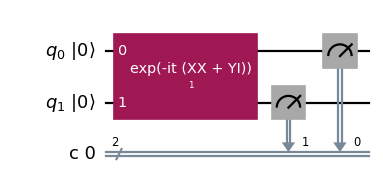

In [161]:
# Some Random Code I guess

from qiskit.quantum_info import Pauli,SparsePauliOp,Operator
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.transpiler import passes
from qiskit.compiler import transpile

# X = Pauli('X')
# Y = Pauli('Y')
X = SparsePauliOp("XX")
Y = SparsePauliOp("YI")
a_dag = 0.5*X-Y
hw = 1.0
H = hw*a_dag 

evol_gate = PauliEvolutionGate(H, time=1, synthesis=SuzukiTrotter(reps=2))

qc = QuantumCircuit(2,2)
qc.append(evol_gate,[0,1])
qc.measure((1,0),(1,0))
qc.draw('mpl',scale=0.8,initial_state=True)

ρ = hni = 2(1 + 2e
βµ + e
2βµ−βU
)
−1
(e
βµ + e
2βµ−βU
)


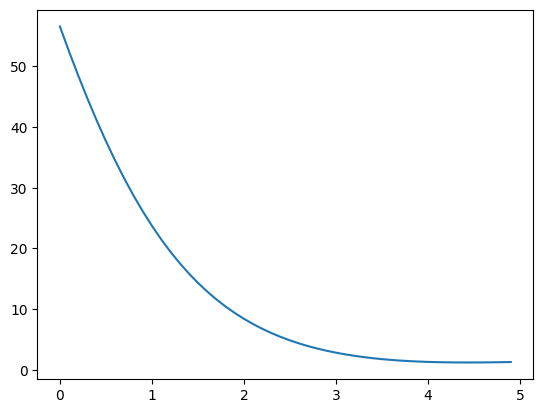

In [173]:
## Analytical results for Fermi HUbbard model

import matplotlib.pyplot as plt

U = 4.0
T = 0.9
mu = np.arange(0,5,0.1)
bm = mu/T
bU = U/T

rho = 2*(np.exp(bU) + np.exp(2*bm - bU))/(1 + 2*np.exp(bm) + np.exp(2*bm - bU))
E = U*np.exp(2*bm - bU)/(1 + 2*np.exp(bm) + np.exp(2*bm - bU))
plt.plot(mu,rho)